In [1]:
from time import perf_counter
import numpy as np # version = 1.24.3
import torch # version = 2.0.0 + cu118
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import ConnectionPatch
import seaborn as sns
from sklearn.datasets import make_regression
from tqdm.notebook import tqdm
from PIL import Image

(20, 1) (20,)


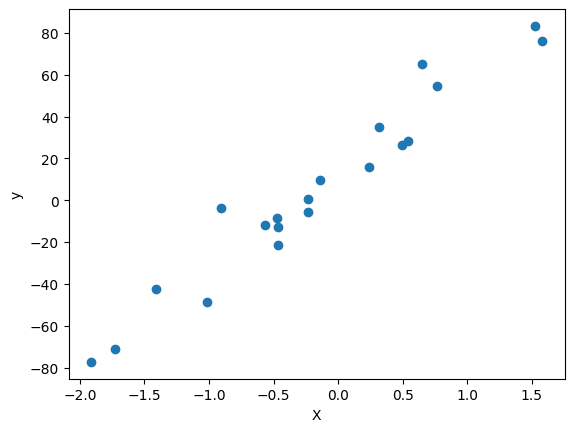

In [183]:
X, y = make_regression(n_samples=20, n_features=1, bias=10, noise=10, random_state=42)
print(X.shape, y.shape)
# plot the data
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()


[84.97339503]


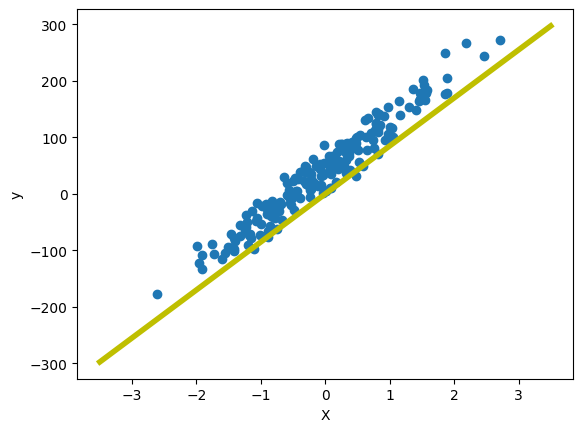

In [4]:
b = np.linalg.inv(X.T @ X) @ X.T @ y
print(b)
x_sample = np.array([-3.5, -2.0, -1.5, -1.0, 0.0, 1.0, 1.5, 2.0, 3.5])
y_line = x_sample * b

plt.plot(x_sample, y_line, linestyle="-", color="y", linewidth=4)
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

## Linear Regression using for-loop
Using numpy for loop based test
Using PyTorch for matmul (CPU, GPU)
Mean squared error
\begin{gather*}
MSE = \frac{1}{n} \sum_{i=1}^{n}(y_i - pred)^2
\end{gather*}

Converting to matrix form:
\begin{gather*}
MSE = (y - (X*m +c)) @ (y - (X.T*m +c)).T
\end{gather*}

Code partially referenced from: https://www.analyticsvidhya.com/blog/2021/06/linear-regression-in-machine-learning/

In [184]:
X.shape, y.shape
# X, y = torch.FloatTensor(X), torch.FloatTensor(y)

iterations = 100
lr = 0.0001
m = 0.0
c = 0.0
error = []
m_list = []
c_list = []

num_samples = X.shape[0]
time_linear_regression_for = []

for itr in tqdm(range(iterations)):
    _t_start = perf_counter()
    error_cost = 0
    cost_m = 0
    cost_c = 0
    for i in range(num_samples):
        y_pred = m * X[i, 0] + c   # predict value for given x
        error_cost = error_cost + (y[i] - y_pred) ** 2
        for j in range(num_samples):
            partial_wrt_c = -2 *(y[j] - (m * X[j, 0] + c))                # partial derivative w.r.t m
            partial_wrt_m = (-2 * X[j, 0]) * (y[j] - (m * X[j, 0] + c))   # partial derivative w.r.t c
            cost_m = cost_m + partial_wrt_m   # calculate cost for each number and add
            cost_c = cost_c + partial_wrt_c   # calculate cost for each number and add
    m = m - lr * cost_m/num_samples    #update m
    c = c - lr * cost_c/num_samples    #update c
    _t_end = perf_counter()

    if itr > 3:
        time_linear_regression_for.append(_t_end - _t_start)
    m_list.append(m)
    c_list.append(c)
    error.append(error_cost)  # Append the data in array

print(np.mean(time_linear_regression_for), np.quantile(time_linear_regression_for, 0.95))

  0%|          | 0/100 [00:00<?, ?it/s]

0.0005143614544067532 0.0008128750050673261


84.33389940360844 12.300692219627598 82657.80550355825


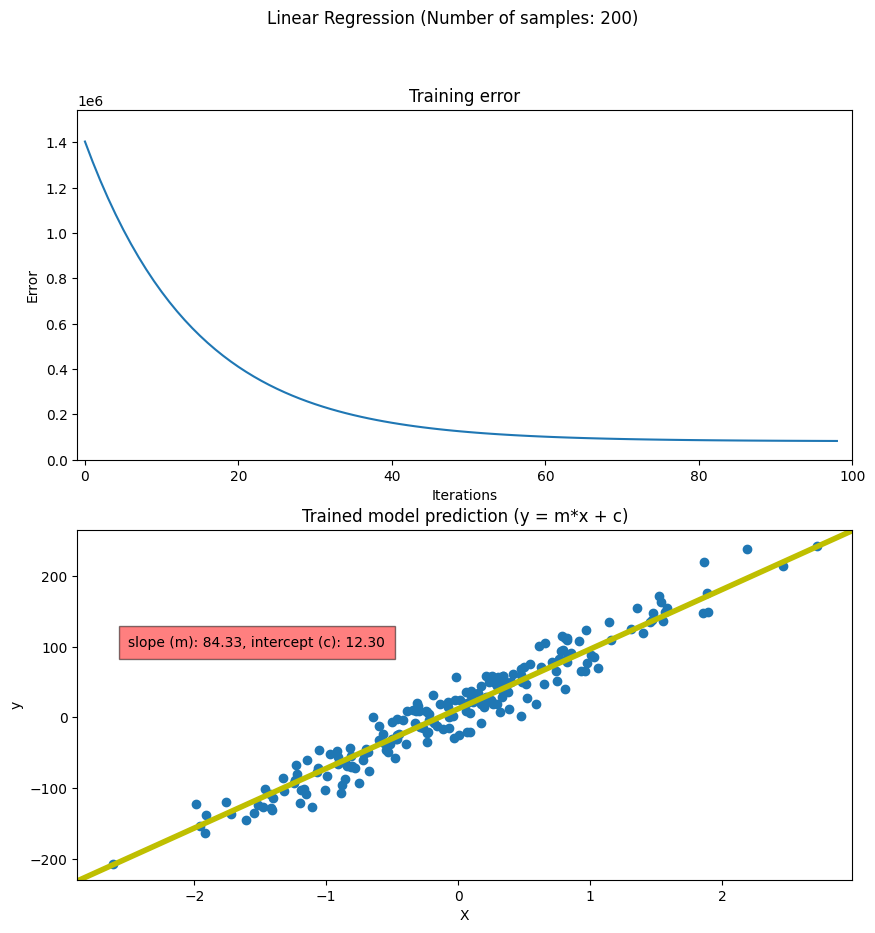

In [143]:
print(m, c, error_cost)
fig, axis = plt.subplots(2, figsize=(10, 10))

fig.suptitle(f"Linear Regression (Number of samples: {X.shape[0]})")
axis[0].set_title("Training error")
axis[0].set_xlabel("Iterations")
axis[0].set_ylabel("Error")
axis[0].set_ylim(0, max(error)*1.1)
axis[0].set_xlim(-1, iterations)
x_sample = np.array([-3.5, -2.0, -1.5, -1.0, 0.0, 1.0, 1.5, 2.0, 3.5])

axis[1].scatter(X, y)
axis[1].set_title("Trained model prediction (y = m*x + c)")
axis[1].set_xlabel('X')
axis[1].set_ylabel('y')

error_plot, = axis[0].plot([])
pred_line_plot, = axis[1].plot([], [], linestyle="-", color="y", linewidth=4)
pred_txt_plot = axis[1].text(-2.5, 100, '', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 7})

def animate(i):
    y_line = x_sample * m_list[i] + c_list[i]
    error_plot.set_data(range(i), error[:i])
    pred_line_plot.set_data(x_sample, y_line)
    pred_txt_plot.set_text(f"slope (m): {m_list[i]:.2f}, intercept (c): {c_list[i]:.2f}")

    return error_plot, pred_line_plot, pred_txt_plot

ani = animation.FuncAnimation(
    fig,
    animate,
    blit=False,
    frames=len(c_list),
)
with Image.new('RGB', (800, 1000), (255, 255, 255)) as bg:
    ani.save('linear_regress_forloop.gif', writer='pillow', fps=5)
plt.show()
plt.close()

## Linear Regression using Matrix Multiplication

In [206]:
## CPU using numpy
X, y = make_regression(n_samples=2000, n_features=1, bias=10, noise=10, random_state=42)
X.shape, y.shape

iterations = 100
lr = 0.0001 #torch.tensor(0.0001).to(gpu_device)
m = 0.0 #torch.tensor(0.0).to(gpu_device)
c = 0.0 #torch.tensor(0.0).to(gpu_device)
print(lr, m, c)
error_matmul = []
m_list_matmul = []
c_list_matmul = []

avg_iter_speed_matmul = []
for itr in tqdm(range(iterations)): 
    t_start = perf_counter()
    y_pred = m * X[:, 0] + c
    diff = y - y_pred
    error_cost = diff @ diff.T

    cost_c = np.sum(-2 * diff)
    cost_m = -2 * X[:, 0] @ diff
    
    m = m - lr * cost_m
    c = c - lr * cost_c
    t_end = perf_counter()

    if itr > 3:
        avg_iter_speed_matmul.append(t_end - t_start)

    m_list_matmul.append(m)
    c_list_matmul.append(c)
    error_matmul.append(error_cost)  # Append the data in array
# avg_iter_speed_matmul = np.mean(avg_iter_speed_matmul)
print(m_list_matmul)
print(np.mean(avg_iter_speed_matmul), np.quantile(avg_iter_speed_matmul, 0.95))
m, c, error_cost

0.0001 0.0 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

[16.047190661102256, 25.72836225960176, 31.574450572243112, 35.10800310622868, 37.24579719050388, 38.54037146823002, 39.32505177465416, 39.801110317815656, 40.09019577283399, 40.26590158688735, 40.37279110553904, 40.43787412093905, 40.47753639740117, 40.50172765010447, 40.516495002850746, 40.52551700389553, 40.53103334335536, 40.5344088469233, 40.536475925153916, 40.537742692966184, 40.5385195653478, 40.53899633161405, 40.53928912079196, 40.53946904458131, 40.53957968061141, 40.53964775274371, 40.539689660777015, 40.539715475697996, 40.539731386074024, 40.53974119715502, 40.53974725015737, 40.53975098638515, 40.5397532936397, 40.539754719078836, 40.53975560009607, 40.539756144842606, 40.53975648179683, 40.53975669029678, 40.53975681935692, 40.5397568992708, 40.53975694876898, 40.53975697943705, 40.53975699844378, 40.53975701022651, 40.539757017532786, 40.539757022064386, 40.53975702487569, 40.539757026620144, 40.53975702770283, 40.539757028374915, 40.5397570287922, 40.53975702905134, 4

(40.539757029476355, 9.87996270374654, 192744.95852759818)

In [137]:
gpu_device = torch.device("cpu")
X_torch, y_torch = torch.FloatTensor(X[:, 0]).to(gpu_device), torch.FloatTensor(y).to(gpu_device)
X.shape, y.shape

iterations = 100*100
lr = torch.tensor(0.0001).to(gpu_device)
m = torch.tensor(0.0).to(gpu_device)
c = torch.tensor(0.0).to(gpu_device)
print(lr, m, c)
error_matmul = []
m_list_matmul = []
c_list_matmul = []

avg_iter_speed_matmul = []
for itr in tqdm(range(iterations)): 
    t_start = perf_counter()
    y_pred = m * X_torch + c
    diff = y_torch - y_pred
    error_cost = diff @ diff.T

    cost_c = torch.sum(-2 * diff)
    cost_m = -2 * X_torch @ diff
    
    m = m - lr * cost_m
    c = c - lr * cost_c
    t_end = perf_counter()

    if itr > 3:
        avg_iter_speed_matmul.append(t_end - t_start)

    m_list_matmul.append(m)
    c_list_matmul.append(c)
    error_matmul.append(error_cost)  # Append the data in array
# avg_iter_speed_matmul = np.mean(avg_iter_speed_matmul)
print(m_list_matmul)
print(np.mean(avg_iter_speed_matmul))
m.detach().cpu().numpy(), c.detach().cpu().numpy(), error_cost.detach().cpu().numpy()

tensor(1.0000e-04) tensor(0.) tensor(0.)


  0%|          | 0/10000 [00:00<?, ?it/s]

[tensor(16.1024), tensor(25.8165), tensor(31.6822), tensor(35.2274), tensor(37.3722), tensor(38.6709), tensor(39.4581), tensor(39.9356), tensor(40.2256), tensor(40.4018), tensor(40.5090), tensor(40.5743), tensor(40.6141), tensor(40.6383), tensor(40.6531), tensor(40.6622), tensor(40.6677), tensor(40.6711), tensor(40.6732), tensor(40.6744), tensor(40.6752), tensor(40.6757), tensor(40.6760), tensor(40.6762), tensor(40.6763), tensor(40.6764), tensor(40.6764), tensor(40.6764), tensor(40.6764), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.6765), tensor(40.676

(array(40.676468, dtype=float32),
 array(9.975993, dtype=float32),
 array(7709.798, dtype=float32))

40.28341920484675 9.699906759366346


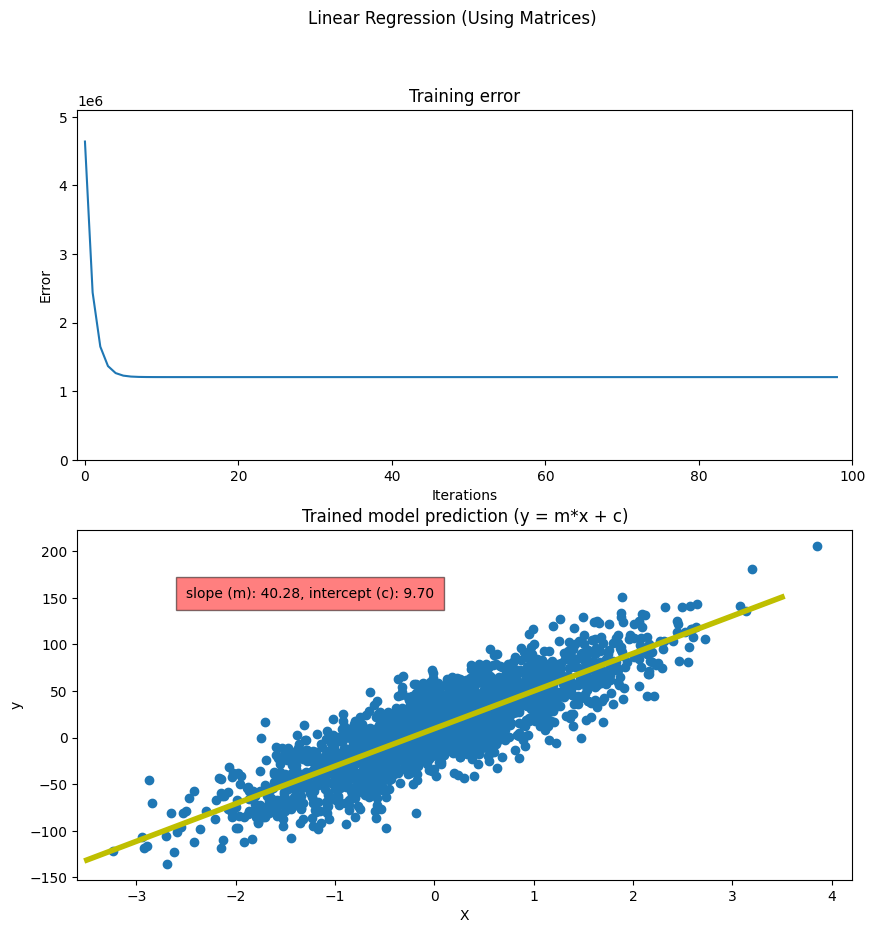

In [25]:
print(m, c)
fig, axis = plt.subplots(2, figsize=(10, 10))

fig.suptitle("Linear Regression (Using Matrices)")
axis[0].set_title("Training error")
axis[0].set_xlabel("Iterations")
axis[0].set_ylabel("Error")
axis[0].set_ylim(0, max(error_matmul)*1.1)
axis[0].set_xlim(-1, iterations)
x_sample = np.array([-3.5, -2.0, -1.5, -1.0, 0.0, 1.0, 1.5, 2.0, 3.5])

axis[1].scatter(X, y)
axis[1].set_title("Trained model prediction (y = m*x + c)")
axis[1].set_xlabel('X')
axis[1].set_ylabel('y')

error_plot, = axis[0].plot([])
pred_line_plot, = axis[1].plot([], [], linestyle="-", color="y", linewidth=4)
pred_txt_plot = axis[1].text(-2.5, 150, '', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 7})

def animate(i):
    y_line = x_sample * m_list_matmul[i] + c_list_matmul[i]
    error_plot.set_data(range(i), error_matmul[:i])
    pred_line_plot.set_data(x_sample, y_line)
    pred_txt_plot.set_text(f"slope (m): {m_list_matmul[i]:.2f}, intercept (c): {c_list_matmul[i]:.2f}")

    return error_plot, pred_line_plot, pred_txt_plot

ani = animation.FuncAnimation(
    fig,
    animate,
    blit=False,
    frames=len(c_list),
)
with Image.new('RGB', (800, 1000), (255, 255, 255)) as bg:
    ani.save('linear_regress_matrix.gif', writer='pillow', fps=5)
plt.show()

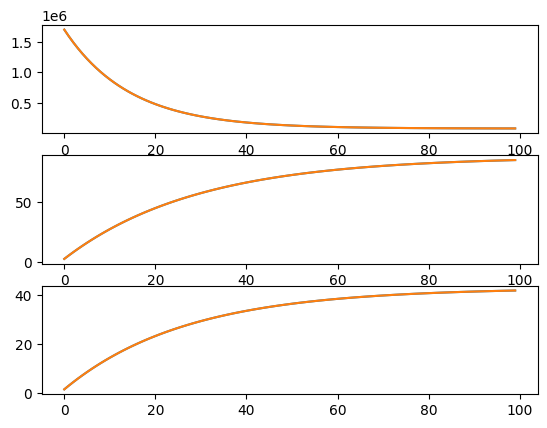

In [20]:
fig, ax = plt.subplots(3)

ax[0].plot(error)
ax[0].plot(error_matmul)
ax[1].plot(m_list)
ax[1].plot(m_list_matmul)
ax[2].plot(c_list)
ax[2].plot(c_list_matmul)

plt.show()